<a href="https://colab.research.google.com/github/thihanaung-thnn/MLnotebooks/blob/main/01_california_house_lr_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing data and libraries

In [33]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [34]:
train_data = pd.read_csv('/content/sample_data/california_housing_train.csv')
test_data = pd.read_csv('/content/sample_data/california_housing_test.csv')

In [35]:
train_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [36]:
test_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0


# EDA

In [37]:
train_data.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [38]:
test_data.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

There is no `Na` values.

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


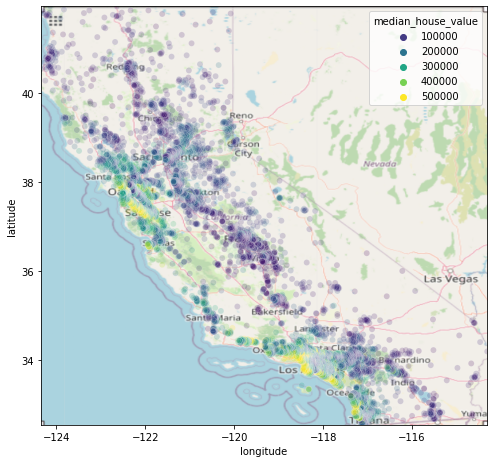

In [40]:
map = plt.imread('map.png')
map_box = ((train_data['longitude'].min(), train_data['longitude'].max(),
            train_data['latitude'].min(), train_data['latitude'].max()))
fig, ax = plt.subplots(figsize=(8,10))
sns.scatterplot(x='longitude', y='latitude', data=train_data, hue='median_house_value', 
                alpha=0.2, ax=ax, palette='viridis')
ax.set_xlim(map_box[0], map_box[1])
ax.set_ylim(map_box[2], map_box[3])
ax.imshow(map, zorder=0, extent=map_box, aspect='equal')

I don't know the cities' names in US but I think the highest house prices are located near San Jose, Oakland, Los Angeles, Oceanside and Tijuna. And I don't know how to handle the location data and I think the longitude and latitude data alone is not useful. I will find the distances from these separate three cities (may be cities) using Euclidean distances.   

> San Jose = 37.3382° N, 121.8863° W   
> Los Angeles = 34.0522° N, 118.2437° W  
> Tijuna = 32.5149° N, 117.0382° W  

In [41]:
sj_coord = [37.3382, -121.8863]
la_coord = [34.0522, -118.2437]
tj_coord = [32.5149, -117.0382]
def calculate_distances(df):
    distances = pd.DataFrame()
    distances['distance_from_sj'] = np.sqrt((df['latitude']-sj_coord[0])**2 + (df['longitude']-sj_coord[1])**2)
    distances['distance_from_la'] = np.sqrt((df['latitude']-la_coord[0])**2 + (df['longitude']-la_coord[1])**2)
    distances['distance_from_tj'] = np.sqrt((df['latitude']-tj_coord[0])**2 + (df['longitude']-tj_coord[1])**2)
    return distances

# I will use these functions later. 

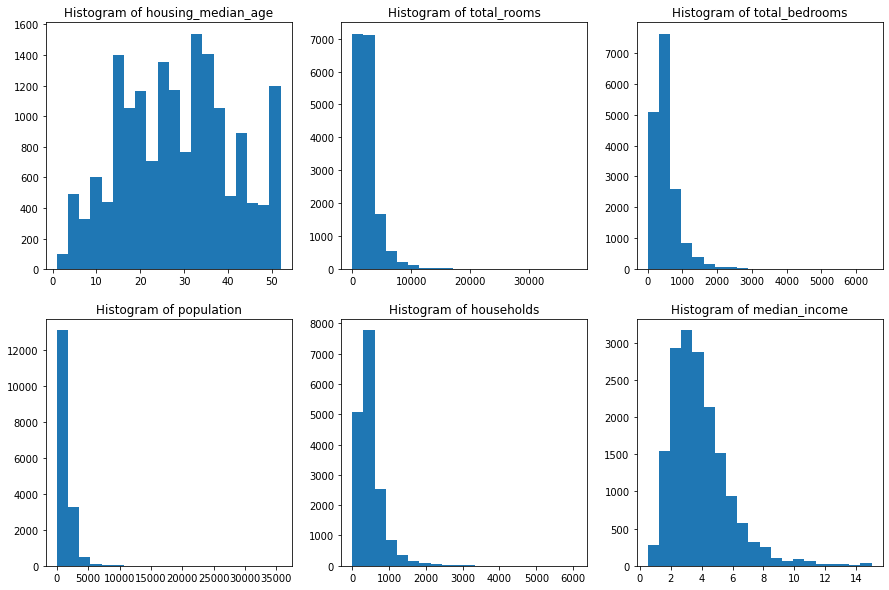

In [42]:
columns = ['housing_median_age', 'total_rooms','total_bedrooms', 'population', 'households', 'median_income']
fig, axes = plt.subplots(2,3, figsize=(15, 10))
for col, ax in zip(columns, axes.flatten()):
    ax.hist(train_data[col], bins=20)
    ax.set_title(f'Histogram of {col}')

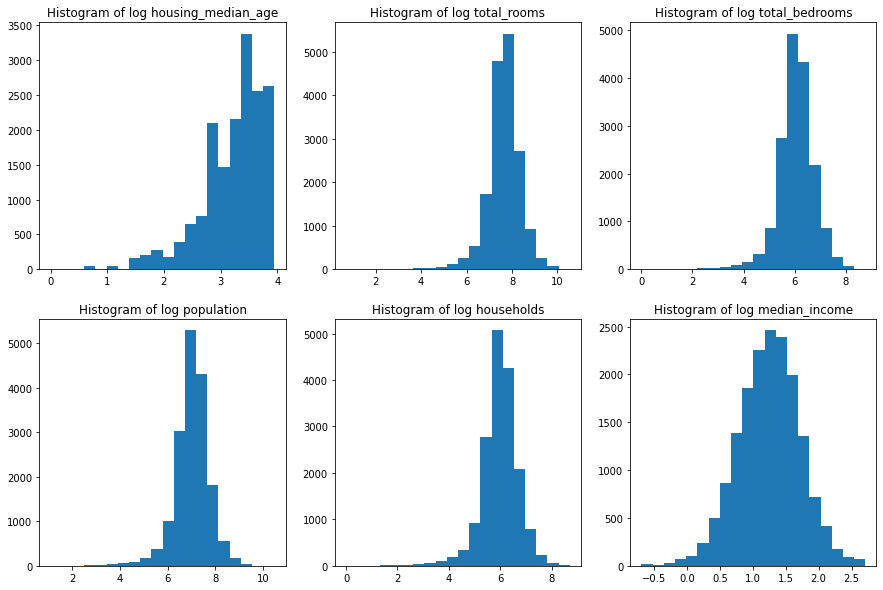

In [43]:
fig, axes = plt.subplots(2,3, figsize=(15, 10))
for col, ax in zip(columns, axes.flatten()):
    ax.hist(np.log(train_data[col]), bins=20)
    ax.set_title(f'Histogram of log {col}')

These variables are good in log transformation except housing median age. 

In [44]:
def log_transform(df):
    log_df = pd.DataFrame()
    columns = ['total_rooms','total_bedrooms', 'population', 'households', 'median_income']
    for col in columns:
        log_df[col] = np.log(df[col])
    return log_df

# I want to use some combinations (feature engineering)
def feature_engineering(df):
    feature_df = pd.DataFrame()
    feature_df['rooms_per_bedrooms'] = df['total_rooms']/df['total_bedrooms']
    feature_df['rooms_per_pop'] = df['total_rooms']/df['population']
    feature_df['households_per_income'] = df['households']/df['median_income']
    return feature_df

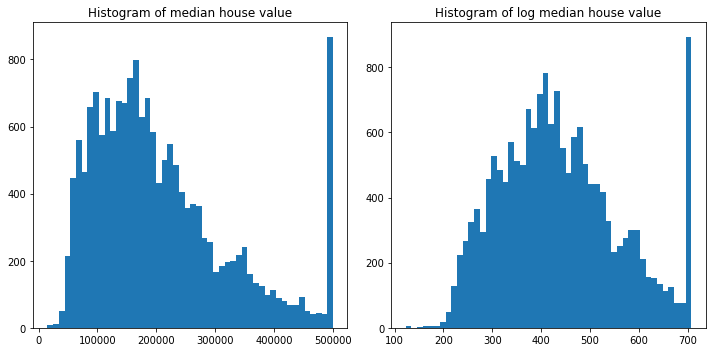

In [45]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(train_data['median_house_value'], bins=50)
plt.title('Histogram of median house value')

plt.subplot(122)
plt.hist(np.sqrt(train_data['median_house_value']), bins=50),
plt.title('Histogram of log median house value')
plt.tight_layout();

The target column has also so many outliers. 

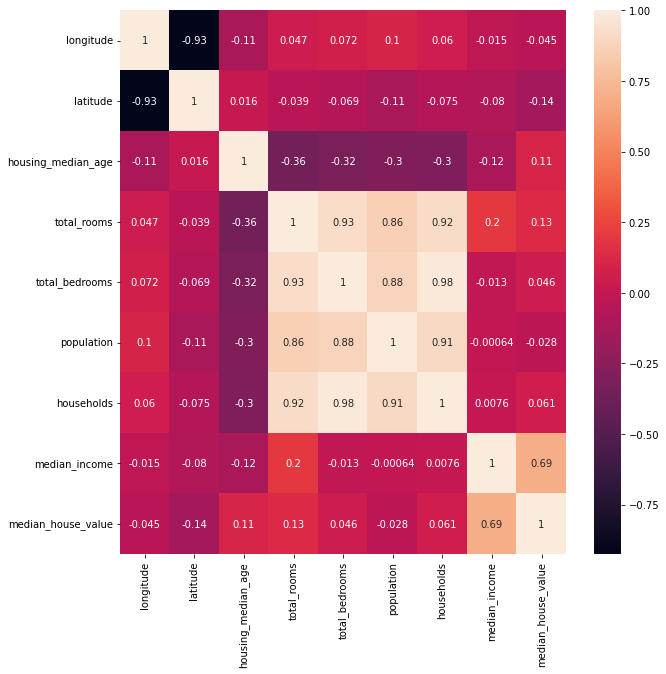

In [46]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(), annot=True);

`Total rooms, population, total_bedrooms and household` are too much correlated to each other. The target value `house-value` is associated with `median-income` and not too much associated with others. I think they are used for analysis as most of the machine learning algorithms will penalize the coefficients to zeros. (it may be wrong)

Let's see only with linear regression. Here I will use only with original features. 

In [47]:
def report_training(X_train, X_test, y_train, y_test):
    pred = lr.predict(X_test)
    mse = np.mean((pred-y_test)**2)
    print(f'Training score: {lr.score(X_train, y_train)}')
    print(f'Testing score: {lr.score(X_test, y_test)}')
    print(f'MSE : {mse}')
    print(f'RMSE: {np.sqrt(mse)}')
    print(f'mean value of the price : {np.mean(y_test)}')

def report_submission(X, y):
    print(f'Submission score: {lr.score(X, y)}')
    pred = lr.predict(X)
    mse = np.mean((pred-y)**2)
    print(f'MSE : {mse}')
    print(f'RMSE: {np.sqrt(mse)}')
    print(f'Mean of price : {np.mean(y)}')
    sns.scatterplot(x=y, y=pred)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual value'); plt.ylabel('Predicted Value')

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,:-1], train_data.iloc[:, -1], 
                                                    random_state=123, test_size=0.3)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
report_training(X_train, X_test, y_train, y_test)

Training score: 0.645821488956261
Testing score: 0.6281630500103272
MSE : 5032614787.676199
RMSE: 70940.92463223326
mean value of the price : 207186.50176470587


Submission score: 0.618401518698005
MSE : 4881330819.156331
RMSE: 69866.52144737371
Mean of price : 205846.275


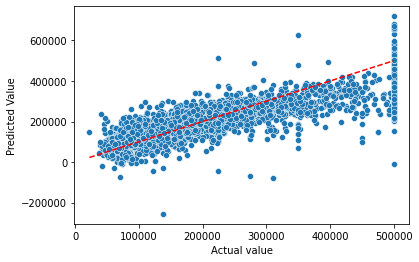

In [49]:
report_submission(test_data.iloc[:,:-1], test_data.iloc[:,-1])

Original mean data with 2 lakhs and RMSE result is 70000. It is not that good. 

What if we remove the correlated columns?

In [50]:
selected_columns = ['longitude', 'latitude', 'housing_median_age','population', 'median_income']
X_train, X_test, y_train, y_test = train_test_split(train_data[selected_columns], train_data.iloc[:,-1],
                                                    test_size=0.3, random_state=123)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
report_training(X_train, X_test, y_train, y_test)

Training score: 0.597800847757687
Testing score: 0.5988885188782
MSE : 5428829952.096861
RMSE: 73680.59413506965
mean value of the price : 207186.50176470587


Submission score: 0.5786580466486315
MSE : 5389721298.890325
RMSE: 73414.72126821925
Mean of price : 205846.275


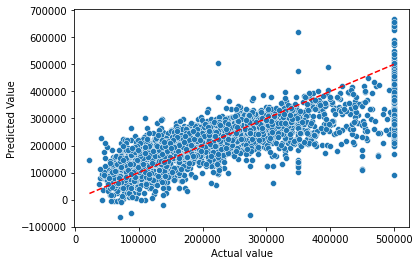

In [51]:
report_submission(test_data[selected_columns], test_data.iloc[:,-1])

Even removing the 3 columns, $R^2$ reduces only 4% and RMSE increases about 3500. 
The effects of outliers have too much impact.
What if we remove the outliers?

In [52]:
def remove_outliers(data):
    q1 = np.percentile(data['median_house_value'], 25, interpolation='midpoint')
    q3 = np.percentile(data['median_house_value'], 75, interpolation='midpoint')
    iqr  =q3 - q1 
    upper = (q3 + 1.5*iqr)
    lower = (q1 - 1.5*iqr)
    no_outlier_df = data[(data['median_house_value'] < upper) & (data['median_house_value'] > lower)]
    return no_outlier_df

Submission score: 0.5718794224944773
MSE : 5476432092.083894
RMSE: 74002.91948351696
Mean of price : 205846.275


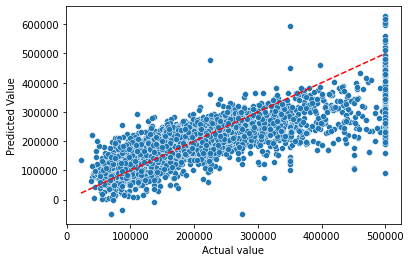

In [53]:
no_outlier_train = remove_outliers(train_data)
X = no_outlier_train[selected_columns]
y = no_outlier_train.iloc[:,-1]
lr = LinearRegression()
lr.fit(X, y)
report_submission(test_data[selected_columns], test_data.iloc[:, -1])

Submission score: 0.6134244367082533
MSE : 4944996648.284257
RMSE: 70320.67013534681
Mean of price : 205846.275


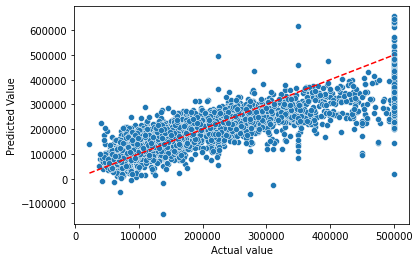

In [54]:
X = no_outlier_train.iloc[:, :-1]
y = no_outlier_train.iloc[:,-1]
lr = LinearRegression()
lr.fit(X, y)
report_submission(test_data.iloc[:, :-1], test_data.iloc[:, -1])

Let's see the results with new features. 

In [55]:
train_data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [62]:
new_features_train = pd.concat([train_data,#[['housing_median_age', 'median_house_value']], 
                                calculate_distances(train_data), 
                                log_transform(train_data),
                                feature_engineering(train_data)], axis=1)

new_features_test = pd.concat([test_data, #[['housing_median_age', 'median_house_value']], 
                                calculate_distances(test_data), 
                                log_transform(test_data),
                                feature_engineering(test_data)], axis=1)

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_scaled = scaler.fit_transform(new_features_train.drop('median_house_value', axis=1))
test_scaled = scaler.transform(new_features_test.drop('median_house_value', axis=1))

Submission score: 0.6508435090922624
MSE : 4466339420.328059
RMSE: 66830.67723978308
Mean of price : 205846.275


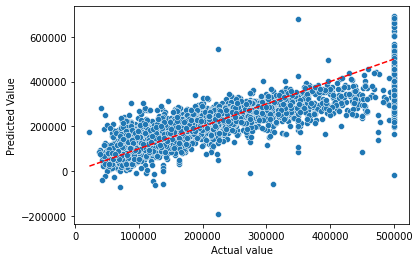

In [64]:
lr = LinearRegression()
lr.fit(train_scaled, new_features_train['median_house_value'])
report_submission(test_scaled, new_features_test['median_house_value'])

It is a lot better. This notebook will end here as it is only used with linear regression. I will find the best model with root mean squared error scoring as I think it is more interpretable and comparable with the original vaules, in the next notebook.